In [1]:
%load_ext autoreload
%autoreload 2


In [50]:
from src.datasets import FunctionDataset, sinusoid
from torch.utils.data import DataLoader

TRAIN_SAMPLES = 1000
TEST_SAMPLES = 10000
function_range = (0, 1)
noise_level = 0.05

sinus_train_dataset = FunctionDataset(
    sinusoid,
    n_samples=TRAIN_SAMPLES,
    range=function_range,
    noise_std=noise_level,
    inverse_function=True,
)
sinus_test_dataset = FunctionDataset(
    sinusoid,
    n_samples=TEST_SAMPLES,
    range=function_range,
    noise_std=0,
    sort=True,
    inverse_function=True,
)

train_dataloader = DataLoader(
    sinus_train_dataset, batch_size=TRAIN_SAMPLES, shuffle=True
)
test_dataloader = DataLoader(sinus_test_dataset, batch_size=TEST_SAMPLES, shuffle=False)


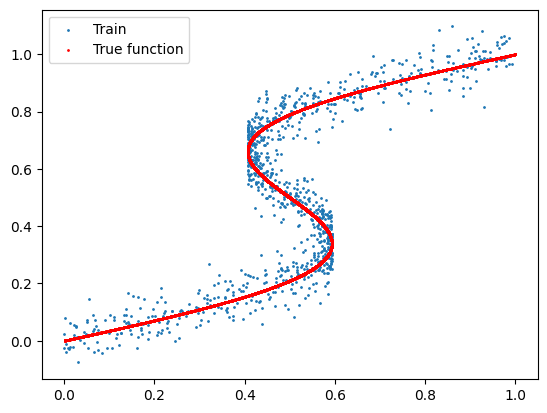

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import torch

plt.scatter(sinus_train_dataset.x, sinus_train_dataset.y, s=1, label="Train")
plt.scatter(
    sinus_test_dataset.x.unsqueeze(1),
    sinus_test_dataset.y.unsqueeze(1),
    color="red",
    label="True function",
    s=1,
)
plt.legend()

plt.show()


100%|██████████| 400/400 [01:06<00:00,  6.04it/s]


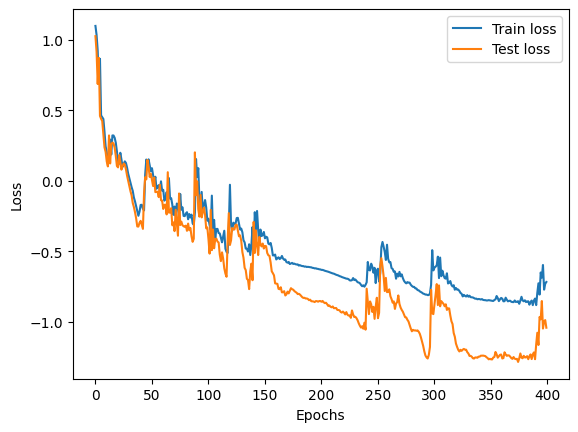

In [52]:
from src.architecture.models import LinearMDN
from src.training import train_loop, mdn_loss, test_loop
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch


EPOCHS = 400
device = "cuda" if torch.cuda.is_available() else "cpu"

mdn_model = LinearMDN(
    input_dimension=1, hidden_dims=[16, 64, 128, 64, 32], output_dimension=1, n_mixtures=3
)
mdn_model.to(device)
optimizer = torch.optim.Adam(mdn_model.parameters(), lr=0.01)

train_losses = []
test_losses = []

for _ in tqdm(range(EPOCHS)):
    train_losses.append(
        train_loop(
            mdn_model,
            train_dataloader,
            optimizer,
            loss_function=mdn_loss,
            device=device,
        )
    )

    test_losses.append(
        test_loop(mdn_model, test_dataloader, loss_function=mdn_loss, device=device)
    )

plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


100%|██████████| 400/400 [01:04<00:00,  6.21it/s]


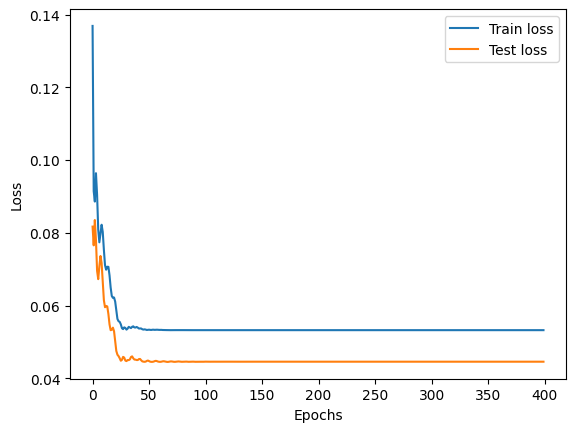

In [4]:
from src.architecture.models import LinearNet
from src.training import train_loop_mse, mse_loss, test_loop_mse
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch


EPOCHS = 400
device = "cuda" if torch.cuda.is_available() else "cpu"

linear_model = LinearNet(input_dimension=1, hidden_dims=[16, 32], output_dimension=1)
linear_model.to(device)
optimizer = torch.optim.Adam(linear_model.parameters(), lr=0.01)

train_losses = []
test_losses = []

for _ in tqdm(range(EPOCHS)):
    train_losses.append(
        train_loop_mse(
            linear_model,
            train_dataloader,
            optimizer,
            loss_function=mse_loss,
            device=device,
        )
    )

    test_losses.append(
        test_loop_mse(
            linear_model, test_dataloader, loss_function=mse_loss, device=device
        )
    )

plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


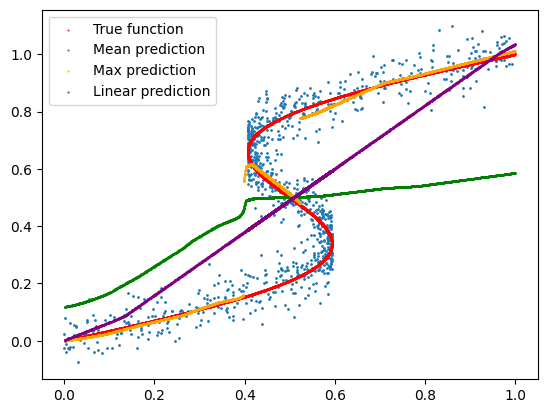

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import torch


x = sinus_test_dataset.x.unsqueeze(1).to(device)
y = sinus_test_dataset.y.unsqueeze(1).to(device)


mu, sigma, pi = mdn_model(x)
linear_pred = linear_model(x)

mean_mu = torch.mean(mu, dim=1)

max_mu_index = torch.argmax(pi, dim=1)

indices = torch.arange(x.shape[0])
max_mu = mu[indices, max_mu_index, :]


plt.scatter(sinus_train_dataset.x, sinus_train_dataset.y, s=1)
plt.scatter(
    x.detach().cpu().numpy(),
    y.detach().cpu().numpy(),
    color="red",
    label="True function",
    s=0.2,
)
plt.scatter(
    x.detach().cpu().numpy(),
    mean_mu.detach().cpu().numpy(),
    color="green",
    label="Mean prediction",
    s=0.2,
)
plt.scatter(
    x.detach().cpu().numpy(),
    max_mu.detach().cpu().numpy(),
    color="orange",
    label="Max prediction",
    s=0.2,

)
plt.scatter(
    x.detach().cpu().numpy(),
    linear_pred.detach().cpu().numpy(),
    color="purple",
    label="Linear prediction",
    s=0.2,

)

plt.legend()

plt.show()


torch.Size([10000]) torch.Size([10000, 3, 1]) torch.Size([10000, 3]) torch.Size([10000, 3])
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10000, 3])
torch.Size([10000])


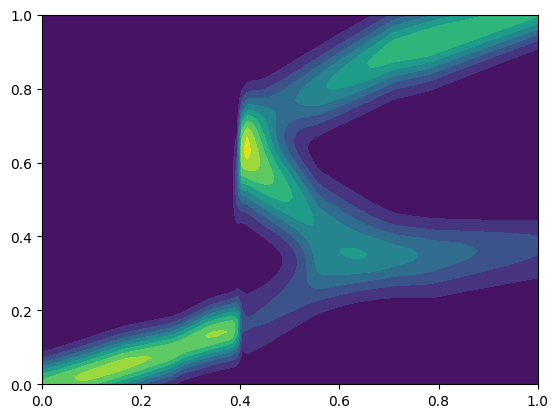

In [54]:
X_dim, Y_dim = 100, 100
X, Y = np.meshgrid(np.linspace(0, 1, X_dim), np.linspace(0, 1, Y_dim))

X_flat = X.flatten()
Y_flat = Y.flatten()

def f(X, Y, model):
    X = torch.from_numpy(X).float().to(device)
    Y = torch.from_numpy(Y).float().to(device)

    mu, sigma, pi = model(X.T.unsqueeze(1))
    output = Y.shape[0]

    print(Y.shape, mu.shape, sigma.shape, pi.shape)

    Y = Y.unsqueeze(1)
    mu = mu.squeeze(2)


    print(type(Y), type(mu))

    exponent = -0.5 * ((Y - mu) / sigma) ** 2
    normalizer = torch.sqrt(2 * torch.pi * sigma ** 2) + 1e-10
    normal_distribution = normalizer * torch.exp(exponent)

    print(normal_distribution.shape)

    sum_pi_normal = torch.sum(pi * normal_distribution, dim=1)

    print(sum_pi_normal.shape)

    return sum_pi_normal.detach().cpu().numpy()

    # return torch.sum(pi * normal_distribution, dim=1).reshape(output, output).detach().cpu().numpy()

Z = f(X_flat, Y_flat, mdn_model)
Z = Z.reshape(X_dim, Y_dim)

plt.contourf(X, Y, Z, 10)#, colors='black')
# plt.plot(sinus_train_dataset.x, sinus_train_dataset.y, "o", color="black", ms=1)